In [1]:
import os
from scTrace.pipeline import *

E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run scTrace+ on LARRY In vitro differentiation time course

In [2]:
dataSet = "Science20-Larry"
samName = "In vitro diff"
run_label = dataSet + "_" + samName

dataPath = "D:/Lineage-data/Science2020-Larry/In vitro differentiation time course/"

# In vitro differentiation time course
data_4 = sc.read(dataPath + 'D4_larry_scobj_down50.h5ad')
data_6 = sc.read(dataPath + 'D6_larry_scobj_down50.h5ad')

In [3]:
savePath = "D:/Lineage-data/Science2020-Larry/Results/" # + run_label + "/"

if not os.path.exists(savePath):
    os.makedirs(savePath)

colors = [#['#B5A2E0', '#F9B475', '#50C7CA', '#CF747A', '#63AFF0', '#8792AF', '#E0CB00', '#DC7EC0'],
          ["#43D9FE", "#E78AC3", "#FEC643", "#A6D854", "#FE6943", "#E5C494", "#33AEB1", "#FFEC1A", "#4878D0", '#984EA3', 
           '#CF747A', '#4DAF4A', '#C2C2C2'],
          ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#4878D0", "#6ACC64", "#82C6E2",
           "#D65F5F", "#43D9FE", '#B383C1', '#BC8967', "#B3B3B3"]]

In [4]:
all_data = [data_4, data_6]
print(data_4.shape)
print(data_6.shape)
all_names = ['Day4', 'Day6']

(24249, 4586)
(27070, 4586)


In [5]:
time = 0

In [6]:
data_pre, data_pos = all_data[time:(time+2)]
pre_name, pos_name = all_names[time:(time+2)]

pre_colors = colors[time]
pos_colors = colors[time+1]

n_pre = data_pre.shape[0]
n_pos = data_pos.shape[0]
run_label_time = run_label + '-' + pre_name + '_' + pos_name
print(run_label_time)

Science20-Larry_In vitro diff-Day4_Day6


In [7]:
cross_sp_df, cross_lin_mat, barcodes_pre, barcodes_pos = prepareCrosstimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                                               lineage_identity='Clone',
                                                                               pre_name=pre_name, pos_name=pos_name,
                                                                               savePath=savePath, run_label_time=run_label_time)

Number of cells in the former time point:  24249
Number of cells with flow-out information:  5385
Flow-out density:  0.2220710132376593
Number of cells in the latter time point:  27070
Number of cells with flow-in information:  11215
Flow-in density:  0.4142962689323975
Generating mother-daughter similarity
0.8830743202212131 0.9004875688405474


In [7]:
sim_mat, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                 lineage_identity='Clone',
                                                 pre_name=pre_name, pos_name=pos_name,
                                                 savePath=savePath, run_label_time=run_label_time,
                                                 mode="pre")

Generating mother-daughter similarity (with-in timepoint)
0.9029274106052435 0.8868751101651757


#### Preparing side information Ku, Kv (run only-once)

In [ ]:
prepareSideInformation(data_pre=data_pre, data_pos=data_pos,
                       barcodes_pre=barcodes_pre, barcodes_pos=barcodes_pos,
                       savePath=savePath,
                       run_label_time=run_label_time,
                       single_inte_fraction=0.5)

#### Split training-validation sets for performance evaluation

In [8]:
train_df, val_df = train_valid_split(cross_sp_df, ratio=0.2, type="stratified")

Splitting train-validation set


In [ ]:
hyper_dict, model = trainMF(train_df=train_df,
                            val_df=val_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

Loading pretrained model...


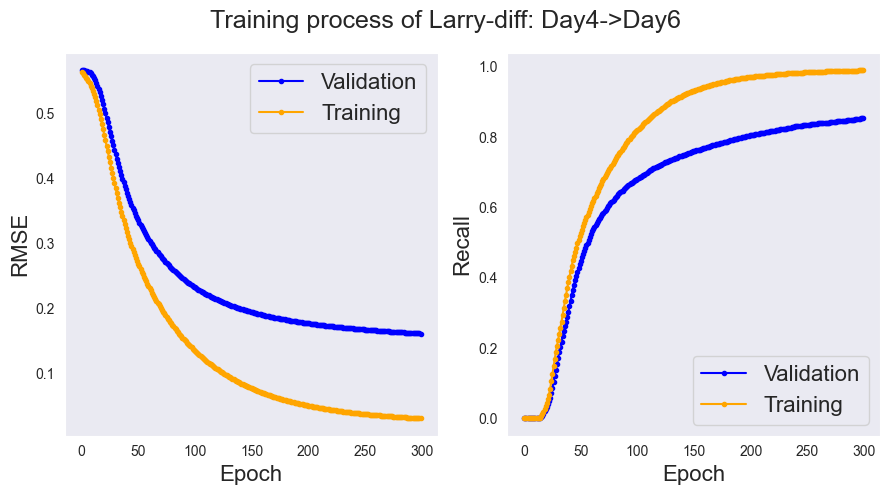

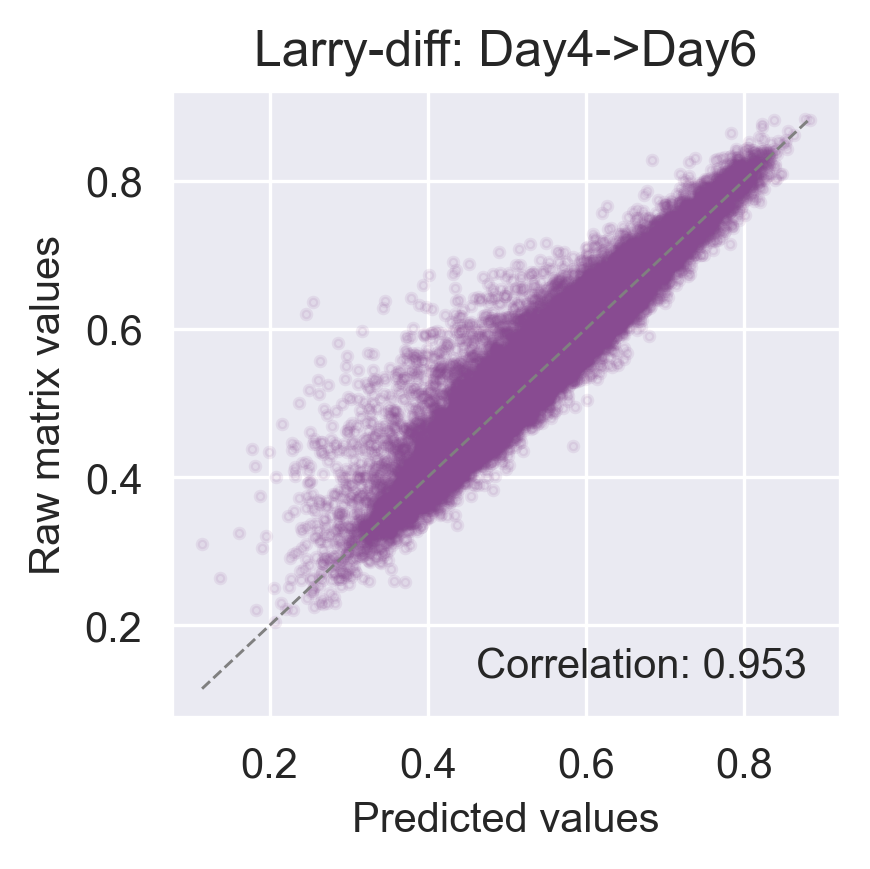

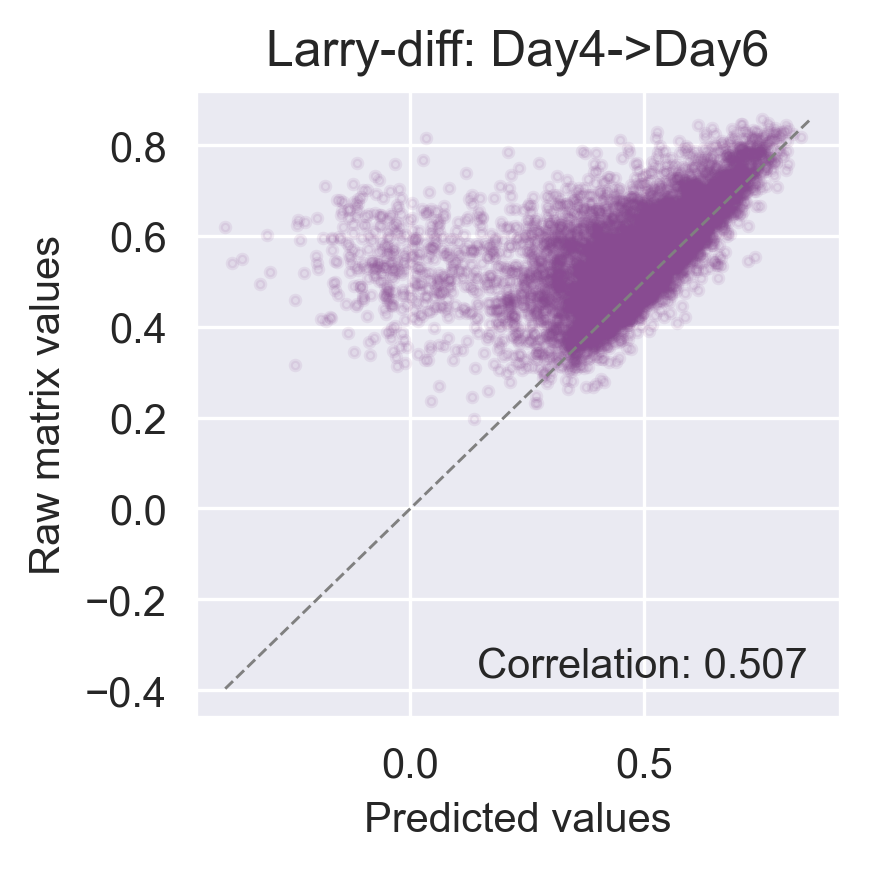

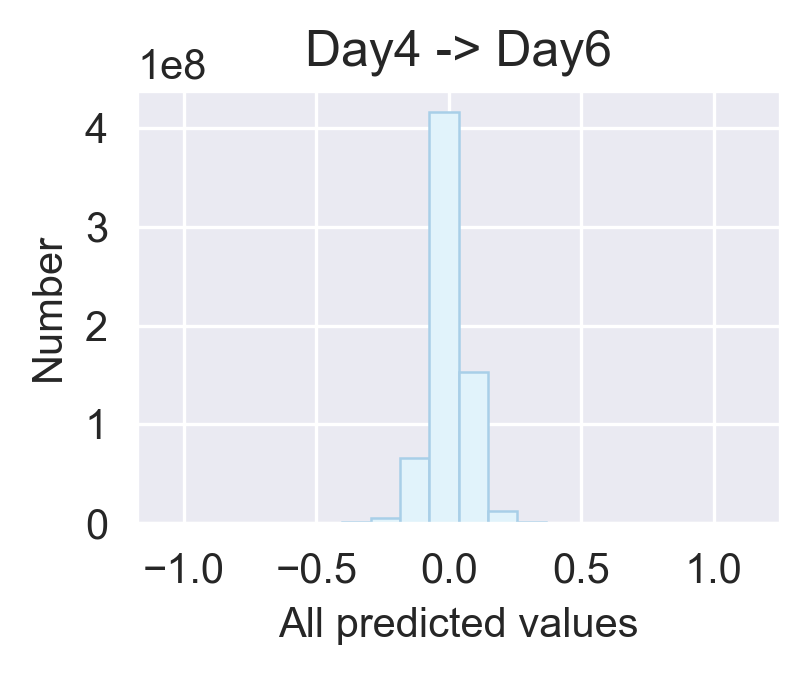

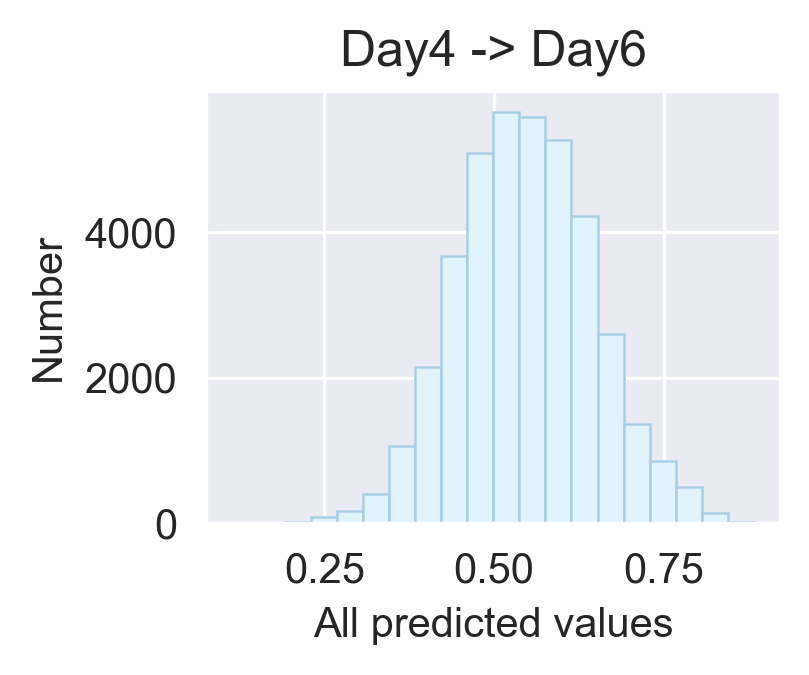

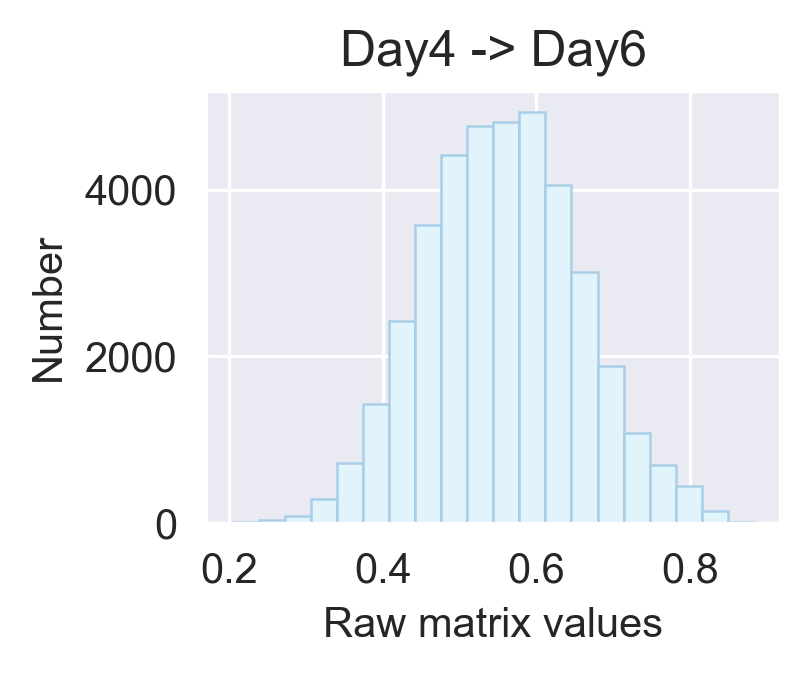

In [10]:
pred_mat, y_true, y_pred, complet_mat, corr, min_rmse, max_recall = predictMissingEntries(pre_name=pre_name,
                                                                                          pos_name=pos_name,
                                                                                          savePath=savePath,
                                                                                          run_label_time=run_label_time,
                                                                                          showName="Larry-diff",
                                                                                          threshold_positive=0.25)

#### Training on full dataset for downstream analysis

In [ ]:
hyper_dict, model = trainMF(train_df=cross_sp_df,
                            val_df=cross_sp_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

#### Load full model for downstream analysis

In [8]:
model = load_model(savePath + "model/" + run_label_time + '_model_full.pkl')

In [9]:
complet_mat = np.dot(model.p, model.q.T)

#### Automatically set the cut-off according to data distribution

In [10]:
basic_values = complet_mat.reshape((1, -1))[0][cross_lin_mat.reshape((1, -1))[0] > 0]
Q1, Q3 = np.percentile(basic_values, 25), np.percentile(basic_values, 75)
threshold = Q1 - 1.5 * (Q3 - Q1)
print(threshold)
complet_mat[complet_mat < threshold] = 0

0.27547700661918517


#### Clustering


## 1. Identify cell clusters and cell states ---------------------------
| - N_cells: [24249, 27070]
| - N_clusters: [6 6]
| - N_cliques: [810 787]
| - Saving figure: D:/Lineage-data/Science2020-Larry/Results/Science20-Larry_In vitro diff-Day4_Day6_Cell-PairUMAP.png


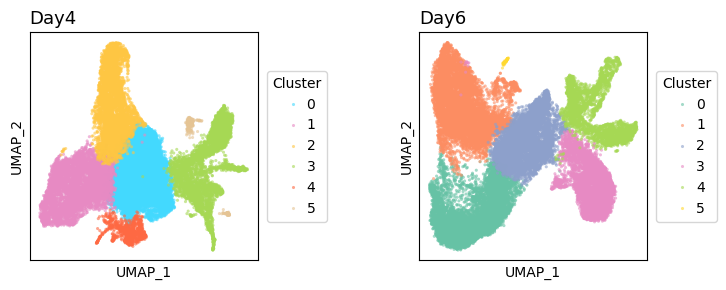

In [12]:
cls_res_all = [0.07, 0.07] # diff data, 0.05 for perturb data
cls_res_all = [0.1, 0.1] # diff data, 0.05 for perturb data
clq_res_all = [50, 50]

scd_obj = prepareScdobj(data_pre=data_pre, data_pos=data_pos,
                        time=time,
                        pre_name=pre_name, pos_name=pos_name,
                        cls_res_all=cls_res_all, clq_res_all=clq_res_all,
                        pre_colors=pre_colors, pos_colors=pos_colors,
                        savePath=savePath, run_label_time=run_label_time)

#### Cluster-level alignment (before and after enhancement)

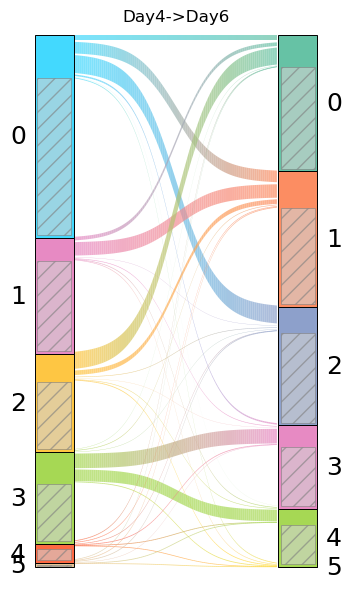

In [13]:
cls_lineage_mat, flow_info = visualizeLineageInfo(scd_obj=scd_obj,
                                                  cross_lin_mat=cross_lin_mat,
                                                  n_pre=n_pre, 
                                                  pre_colors=pre_colors, pos_colors=pos_colors,
                                                  pre_name=pre_name, pos_name=pos_name,
                                                  savePath=savePath,
                                                  run_label_time=run_label_time)

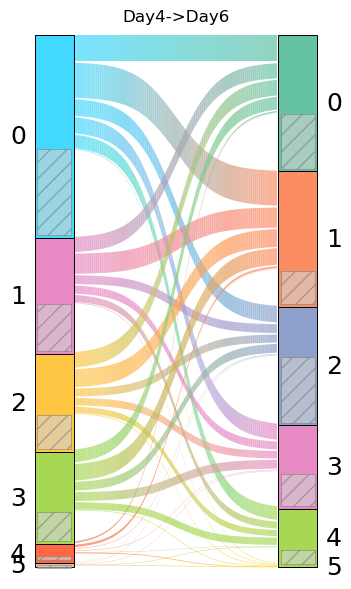

In [30]:
cls_trans_mat, flow_info_enhanced = visualizeEnhancedLineageInfo(scd_obj=scd_obj,
                                                                 complet_mat=complet_mat,
                                                                 n_pre=n_pre, 
                                                                 pre_colors=pre_colors, pos_colors=pos_colors,
                                                                 pre_name=pre_name, pos_name=pos_name,
                                                                 savePath=savePath,
                                                                 run_label_time=run_label_time)

#### Assign fate according to lineage information

In [13]:
scd_obj, metrics = assignLineageInfo(scd_obj,
                                     cross_lin_mat,
                                     savePath,
                                     run_label_time,
                                     sel_cluster_name="Cell type annotation")

Cell fate randomness: 0.3273 Neighboring cell fate similarity: 0.6354
Neighboring cell fate consistency: 0.5900 Neighboring cell fate randomness: 0.5242


E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [14]:
adata_pre, enhance_rate = enhanceFate(scd_obj,
                                      complet_mat,
                                      savePath,
                                      run_label_time,
                                      cluster_name='Cell type annotation')

100%|██████████| 24249/24249 [00:15<00:00, 1563.49it/s]
E:\Lineage\Code\scTrace\scTrace\pipeline.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_pre.obs[enhanced_fate_colname][i] = cell_fate_cls[i]


Ratio of newly added fate clusters: 0.2195


E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


#### Run DEGs (before and after enhancement)

#### Select fates (Recommend)

In [15]:
sel_cls = 'Undifferentiated'
sel_fates = ['Undifferentiated -> Undifferentiated', 'Undifferentiated -> Monocyte']
cls_colname, fate_colname = 'Cell type annotation', 'Lineage_fate_label'
lt_sub_expr, lt_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                               saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')
cls_colname, fate_colname = 'Cell type annotation', 'Enhanced_fate_label'
eh_sub_expr, eh_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                            saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')

E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


#### All fates (1 v.s. rest)

In [16]:
all_de_df_lt = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                   sel_cluster_name="Cell type annotation",
                                   fate_colname='Lineage_fate',
                                   special_case="Missing")
all_de_df_enhanced = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                         sel_cluster_name="Cell type annotation",
                                         fate_colname='Enhanced_fate',
                                         special_case="Uncertain")

E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\

division by zero


E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-pack

division by zero


E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\pgm_env\lib\site-pack

#### Save results

In [19]:
pre_df = adata_pre.obs[['cluster', 'Cell type annotation', 'Lineage_fate', 'Lineage_fate_label', 'Enhanced_fate', 'Enhanced_fate_label']]
pre_df.to_csv(savePath + run_label_time + ' - res_anno' + '_'  + str(threshold) + '.txt', sep = '\t')